# Importing Libraries

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycaret
import glob
import os
import math
import warnings
import matplotlib
warnings.filterwarnings("ignore")
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=30)
font = {'size'   : 35,
        'weight' : 'bold'}
matplotlib.rc('font', **font)
zone_colours = ["blue","red"]
import lasio
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from matplotlib.colors import ListedColormap

# Loading Data

In [142]:
a = pd.read_csv(r".\QC\Well_15_9-F-11B.csv")
a["LLD"] = 10**a["LLD"]
a["CORR LLD"] = 10**a["CORR LLD"]
a = a.sort_values(by="DEPTH")
a

,DEPTH,GR,LLD,RHOB,NPHI,Formation,CORR GR,CORR LLD,CORR RHOB,CORR NPHI
0,3198.2,9.040,9.525,2.599,0.077,Hod Fm. Top,9.040,9.525,2.599,0.077
1,3198.3,9.933,9.488,2.609,0.071,Hod Fm. Top,9.933,9.488,2.609,0.071
2,3198.4,10.037,9.467,2.609,0.069,Hod Fm. Top,10.037,9.467,2.609,0.069
3,3198.5,8.748,9.511,2.606,0.068,Hod Fm. Top,8.748,9.511,2.606,0.068
4,3198.6,9.243,9.437,2.601,0.067,Hod Fm. Top,9.243,NaN,2.601,NaN
...,...,...,...,...,...,...,...,...,...,...
15319,4731.5,26.995,16.995,2.688,0.046,Hugin Fm. VOLVE Top,26.995,16.995,2.688,NaN
15320,4731.6,25.603,16.467,2.674,0.046,Hugin Fm. VOLVE Top,NaN,16.467,2.674,NaN
15321,4731.7,25.915,15.692,2.655,0.048,Hugin Fm. VOLVE Top,25.915,15.692,2.655,NaN
15322,4731.8,27.293,14.708,2.632,0.051,Hugin Fm. VOLVE Top,NaN,14.708,2.632,NaN


# Volume of Clay Calculation

In [143]:
 a["Clay Volume-Linear"] = ((a["CORR GR"]-a["CORR GR"].min())/(a["CORR GR"].max()-a["CORR GR"].min()))

In [144]:
reservoir=[]
for i in a["Formation"].unique():
    b = a[a["Formation"]==i]
    reservoir.append(b)

# Density Porosity Calculation


In [145]:
def Porosities(_3):
    _3["Density Porosity"] = ((_3["CORR RHOB"]-2.71)/(1-2.71))
    return _3

In [146]:
reservoir = [Porosities(i) for i in reservoir]

# Effective Porosity Calculation

In [147]:
def effective_poro(_3):
    _3["Average Porosity"] = (_3["Density Porosity"])
    Porosity = _3[_3["Clay Volume-Linear"]==_3["Clay Volume-Linear"].max()]["Average Porosity"].values[0]
    _3["Clay Effect"] = (_3["Clay Volume-Linear"])*Porosity
    _3["Effective Porosity"] = _3["Average Porosity"] - _3["Clay Effect"]
    index = _3[_3["Effective Porosity"]<0].index
    _3.loc[index,"Effective Porosity"]=0
    return _3

In [148]:
reservoir = [effective_poro(i) for i in reservoir]

In [149]:
all_ = pd.concat(reservoir)

# Simandoux Water Saturation Calculation

In [150]:
a= 1
rw = 0.1
m = 2
n = 2
def sw_simandoux(_3):
    rt = _3["CORR LLD"]
    Rsh = _3[_3["Clay Volume-Linear"]==_3["Clay Volume-Linear"].max()]["CORR LLD"].values[0]
    A = (1 - _3["Clay Volume-Linear"] * a * rw) / (_3["Effective Porosity"] ** 2)
    B = A * _3["Clay Volume-Linear"] / (2 * Rsh)
    C = A /rt
    _3["SW"]= ((B **2 + C)**0.5 - B) **(2 / n)
    f = _3[_3["SW"]>1].index
    _3.loc[f,"SW"]=1
    _3.loc[_3.loc[_3["SW"].isna()].index,"SW"]=1
    return _3

In [151]:
reservoir = [sw_simandoux(i) for i in reservoir]

In [152]:
all_ = pd.concat(reservoir)


# Visualizing Well Logs

In [153]:
a = all_.copy().interpolate(kind="cubic").dropna(how="any").reset_index(drop=True)
m = int(a["CORR GR"].max())
d = []
for i in a["CORR GR"]:
    z = np.nan*(np.ones(m))
    z[:int(i)+1] = i
    z = z.reshape(1,-1)
    d.append(z)
gr = pd.DataFrame(np.concatenate(d))
gr["data"] = a["CORR GR"]
tops_unique = a["Formation"].unique()
tops_n=[]
tops_depth=[]
lims=[]
for i in tops_unique:
    min1 = a[a["Formation"]==i]["DEPTH"].min()
    min2 = a[a["Formation"]==i]["DEPTH"].max()
    forms = list(tops_unique)
    tops_depth.append(min1)  
    tops_n.append((min1+min2/2))
    lims.append((min1,min2))
color = sns.color_palette("Paired", len(forms))
z1 = a.groupby(by="Formation").mean()
a["VCL"] = a["Clay Volume-Linear"]

# Reservoir Facies Cut Offs

In [154]:
def Facies(well):
    well["Facies"]=1
    shale=well[well["VCL"]>0.3].index
    wet=well[(well["VCL"]<=0.3)&(well["SW"]>0.45)].index
    gas=well[(well["VCL"]<=0.3)&(well["SW"]<=0.45)].index
    
    well.loc[shale,"Facies"]=1
    well.loc[gas,"Facies"]=2
    well.loc[wet,"Facies"]=3
    return well
facies_color = ListedColormap(["lime","red","blue"])

In [155]:
Facies(a)

,DEPTH,GR,LLD,RHOB,NPHI,Formation,CORR GR,CORR LLD,CORR RHOB,CORR NPHI,Clay Volume-Linear,Density Porosity,Average Porosity,Clay Effect,Effective Porosity,SW,VCL,Facies
0,3198.2,9.040,9.525,2.599,0.077,Hod Fm. Top,9.040,9.525,2.599,0.077,0.058824,0.064912,0.064912,0.003234,0.061679,1.0,0.058824,3
1,3198.3,9.933,9.488,2.609,0.071,Hod Fm. Top,9.933,9.488,2.609,0.071,0.067512,0.059064,0.059064,0.003711,0.055353,1.0,0.067512,3
2,3198.4,10.037,9.467,2.609,0.069,Hod Fm. Top,10.037,9.467,2.609,0.069,0.068524,0.059064,0.059064,0.003767,0.055297,1.0,0.068524,3
3,3198.5,8.748,9.511,2.606,0.068,Hod Fm. Top,8.748,9.511,2.606,0.068,0.055983,0.060819,0.060819,0.003077,0.057741,1.0,0.055983,3
4,3198.6,9.243,9.437,2.601,0.067,Hod Fm. Top,9.243,9.518,2.601,0.067,0.060799,0.063743,0.063743,0.003342,0.060401,1.0,0.060799,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,4373.5,18.402,123.332,2.300,0.144,Hugin Fm. VOLVE Base,18.402,123.332,2.300,0.144,0.149911,0.239766,0.239766,0.017525,0.040954,1.0,0.149911,3
15320,4373.6,20.436,140.916,2.306,0.140,Hugin Fm. VOLVE Base,20.436,140.916,2.307,0.140,0.169701,0.235673,0.235673,0.017525,0.040954,1.0,0.169701,3
15321,4373.7,23.101,422.773,2.314,0.136,Hugin Fm. VOLVE Base,23.101,422.773,2.314,0.136,0.195630,0.231579,0.231579,0.017525,0.040954,1.0,0.195630,3
15322,4373.8,25.963,32075.068,2.325,0.132,Hugin Fm. VOLVE Base,25.963,32075.068,2.326,0.132,0.223475,0.224561,0.224561,0.017525,0.040954,1.0,0.223475,3


In [156]:
def cos(asdds,asd1):
    import matplotlib
    warnings.filterwarnings("ignore")
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=30)
    font = {'size'   : 35,
            'weight' : 'bold'}
    matplotlib.rc('font', **font)
    zone_colours = ["blue","red"]
    # a1 = a[a["Formation"] == "XVa (TOP)"]
    a1 = a[(a["DEPTH"]>asdds)&(a["DEPTH"]<asd1)]
    tops_unique = a1["Formation"].unique()
    tops_n=[]
    tops_depth=[]
    lims=[]
    for i in tops_unique:
        min1 = a1[a1["Formation"]==i]["DEPTH"].min()
        min2 = a1[a1["Formation"]==i]["DEPTH"].max()
        forms = list(tops_unique)
        tops_depth.append(min1)  
        tops_n.append((min1+min2/2))
        lims.append((min1,min2))
    color = sns.color_palette("Paired", len(forms))
    plotting = ["Formation","CORR GR","CORR RHOB","CORR LLD","VCL","Effective Porosity","SW","Facies"]
    fig,ax = plt.subplots(nrows=1,ncols=len(plotting),figsize=(27,10),sharey=True)
    fig.subplots_adjust(wspace=0.12)
    for j,i in enumerate(plotting):
        if i=="Formation":
            for aj,ai in enumerate(tops_depth):
                ax[j].text( x = 0.5,  y = tops_depth[aj], s = forms[aj],fontsize = '20', 
                        horizontalalignment = 'center',verticalalignment = 'bottom')
                ax[j].grid(False)
                ax[j].set_xticks([])
        elif i=="VCL":
            ax[j].fill_betweenx(a1['DEPTH'],a1["VCL"],0, interpolate=True, color='green')
            ax[j].fill_betweenx(a1['DEPTH'],1,a1["VCL"], interpolate=True, color='yellow')
            ax[j].plot(a1["VCL"],a1["DEPTH"],color="black")

            ax[j].set_title("Clay\nVolume",fontdict={"fontsize":30,"fontweight":'bold'})

        elif i=="Effective Porosity":
            ax[j].fill_betweenx(a1['DEPTH'],a1["Effective Porosity"],0, interpolate=True, color='brown')
            ax[j].fill_betweenx(a1['DEPTH'],1,a1["Effective Porosity"], interpolate=True, color='black')
            ax[j].plot(a1["Effective Porosity"],a1["DEPTH"],color="black")
            ax[j].set_xlim([0,a1["Effective Porosity"].max()])
            ax[j].set_title("PHIE",fontdict={"fontsize":30,"fontweight":'bold'})
        elif i=="SW":
            ax[j].fill_betweenx(a1['DEPTH'],a1["SW"],0, interpolate=True, color='blue')
            ax[j].fill_betweenx(a1['DEPTH'],1,a1["SW"], interpolate=True, color='red')
            ax[j].plot(a1["SW"],a1["DEPTH"],color="black")
            ax[j].set_xlim([0,0.45])
            ax[j].set_title("SW",fontdict={"fontsize":30,"fontweight":'bold'})
        elif i=="CORR RHOB":
            ax[j].plot(a1[i],a1["DEPTH"])
            ax[j].spines["top"].set_position(("axes", 1))

            ax[j].spines["top"].set_visible(True)
            ax[j].spines["top"].set_edgecolor("blue")
            ax[j].set_xlabel("CORR\nRHOB",fontdict={"fontsize":30,"fontweight":'bold'})
            ax[j].xaxis.set_label_position("top")

        elif i=="CORR LLD":
            ax[j].semilogx(a1[i],a1["DEPTH"])
            ax[j].set_title(i,fontdict={"fontsize":30,"fontweight":'bold'})  
        elif i=="CORR GR":
            cbaxes = fig.add_axes([0.22, 1.05, 0.1, 0.02])
            a0 = ax[j].imshow(gr,aspect="auto",cmap="nipy_spectral",extent=[a1["CORR GR"].min(),a1["CORR GR"].max(),a1["DEPTH"].max(),a1["DEPTH"].min()])
            fig.colorbar(a0,orientation="horizontal",cax=cbaxes)
            ax[j].fill_betweenx(a1['DEPTH'],a1["CORR GR"], a1["CORR GR"].max(), interpolate=True, color='white')
            ax[j].set_title("CORR\nGR",fontdict={"fontsize":30,"fontweight":'bold'})
            ax[j].grid(False)

            ax[j].set_title(i,fontdict={"fontsize":30,"fontweight":'bold'})
        elif i=="CALI":
            ax[j].plot(a1["CALI"],a1["DEPTH"],color="red",la1bel="CALI")
            ax[j].set_title(i,fontdict={"fontsize":30,"fontweight":'bold'})
        elif i=="DT":
            ax[j].plot(a1[i],a1["DEPTH"])
            ax[j].spines["top"].set_position(("axes", 1))

            ax[j].spines["top"].set_visible(True)
            ax[j].spines["top"].set_edgecolor("blue")
            ax[j].set_xlabel("DT",fontdict={"fontsize":30,"fontweight":'bold'})
            ax[j].xaxis.set_label_position("top")


        elif i=="CORR NPHI":
            ax[j].plot(a1[i],a1["DEPTH"])
            ax[j].spines["top"].set_position(("axes", 1))
            ax[j].spines["top"].set_visible(True)
            ax[j].spines["top"].set_edgecolor("blue")

            ax[j].set_xlabel("CORR\nNPHI",fontdict={"fontsize":30,"fontweight":'bold'})
            ax[j].xaxis.set_label_position("top")


        elif (i!="Formation")&(i!="crossover")&(i!="Facies"):
            ax[j].plot(a1[i],a1["DEPTH"])
            ax[j].set_xticks([])
            ax[j].set_title(i,fontdict={"fontsize":15,"fontweight":'bold'})
        elif i=="crossover":

            x1=a1['CORR RHOB']
            x2=a1['CORR NPHI']
            x = np.array([x1.min(),x1.max()])
            z = np.array([x2.min(),x2.max()])
            nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)
            ax[j].fill_betweenx(a1['DEPTH'], x1, nz, where=x1>=nz, interpolate=True, color='green')
            ax[j].fill_betweenx(a1['DEPTH'], x1, nz, where=x1<=nz, interpolate=True, color='yellow')

            ax[j].plot(a1["CORR RHOB"],a1["DEPTH"],color="red",label="CORR RHOB")
            ax[j].set_xlim([a1["CORR RHOB"].min(),a1["CORR RHOB"].max()])
            ax[j].set_xticks([])
            ax[j] = ax[j].twiny()
            ax[j].plot(a1["CORR NPHI"],a1["DEPTH"],color="blue",label="CORR CORR NPHI")
            ax[j].set_xlim([a1["CORR NPHI"].max(),a1["CORR NPHI"].min()])

            ax[j].spines["top"].set_position(("axes", 1))
            ax[j].spines["top"].set_visible(True)
            ax[j].spines["top"].set_edgecolor("blue")
            ax[j].set_xlim([a1["CORR NPHI"].max(),a1["CORR NPHI"].min()])

            ax[j].set_xticks([])
            ax[j].set_xlabel("Crossover",fontdict={"fontsize":30,"fontweight":'bold'})
        elif i=="Facies":
            left_col_value = 0
            right_col_value = 3
            curve = a1['Facies']
            span = abs(left_col_value - right_col_value)
            cmap = facies_color
            color_index = np.arange(left_col_value, right_col_value, span / 100)
            for index in sorted(color_index):
                index_value = (index - left_col_value)/span
                color = cmap(index_value) #obta1in colour for color index va1lue
                ax[j].fill_betweenx(a1['DEPTH'], 0 , curve, where = curve >= index,  color = color)
            ax[j].set_xlim([0,1])
            ax[j].set_title("Facies",fontdict={"fontsize":30,"fontweight":'bold'})
            ax[j].set_xticks([])



        for k,i in enumerate(lims):
            if j!=len(plotting)-1:
                ax[j].axhline(i[1], color = 'black')     
        ax[0].set_ylabel("DEPTH (feets)")
    b = a1.groupby(by="Facies").mean()
    try:
        b.index= ["Shale","Gas Sand","Wet Sand"]
        palette=["Lime","Red","blue"]
    except:
        b.index= ["Shale","Wet Sand"]
        palette=["Lime","blue"]
    c = b[["Average Porosity","VCL","Effective Porosity","SW"]].reset_index()
    d = pd.DataFrame(c.mean())
    try:
        d.loc["SW"] = c[c["index"]=="Gas Sand"]["SW"].values
    except:
        pass
    d1 = d.transpose()

    import matplotlib
    warnings.filterwarnings("ignore")
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    font = {'size'   : 15,
            'weight' : 'bold'}
    matplotlib.rc('font', **font)
    zone_colours = ["blue","red"]
    fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,10))
    fig.subplots_adjust(wspace=0.3)
    sns.histplot(data=a1, x="VCL", hue="Facies",palette=palette,kde=True,ax=ax[0,0])
    ax[0,0].legend(["WetSand","GasSand","Shale"])
    sns.histplot(data=a1, x="Effective Porosity", hue="Facies",palette=palette,kde=True,ax=ax[0,1])
    ax[0,1].legend(["WetSand","GasSand","Shale"])
    sns.histplot(data=a1, x="SW", hue="Facies",palette=palette,kde=True,ax=ax[0,2])
    ax[0,2].legend(["WetSand","GasSand","Shale"])
    sns.barplot(c, x="VCL", y="index", hue="index",palette=palette,width=0.4,ax=ax[1,0])
    ax[1,0].set_ylabel("Facies")
    ax[1,0].legend([])
    sns.barplot(c, x="Effective Porosity", y="index", hue="index",palette=palette,width=0.4,ax=ax[1,1])
    ax[1,1].set_ylabel("")
    ax[1,1].legend([])
    sns.barplot(c, x="SW", y="index", hue="index",palette=palette,width=0.4,ax=ax[1,2])
    ax[1,2].set_ylabel("")
    ax[1,2].legend([])
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,1))
    sns.heatmap(d1,annot=True,cbar=False,ax=ax)
    ax.set_yticklabels(["Average"])
    d1["Pay Thickness"] = len(a1[a1["Facies"]==2])*.25
    print(d1)

In [157]:
a = a.sort_values(by="DEPTH")

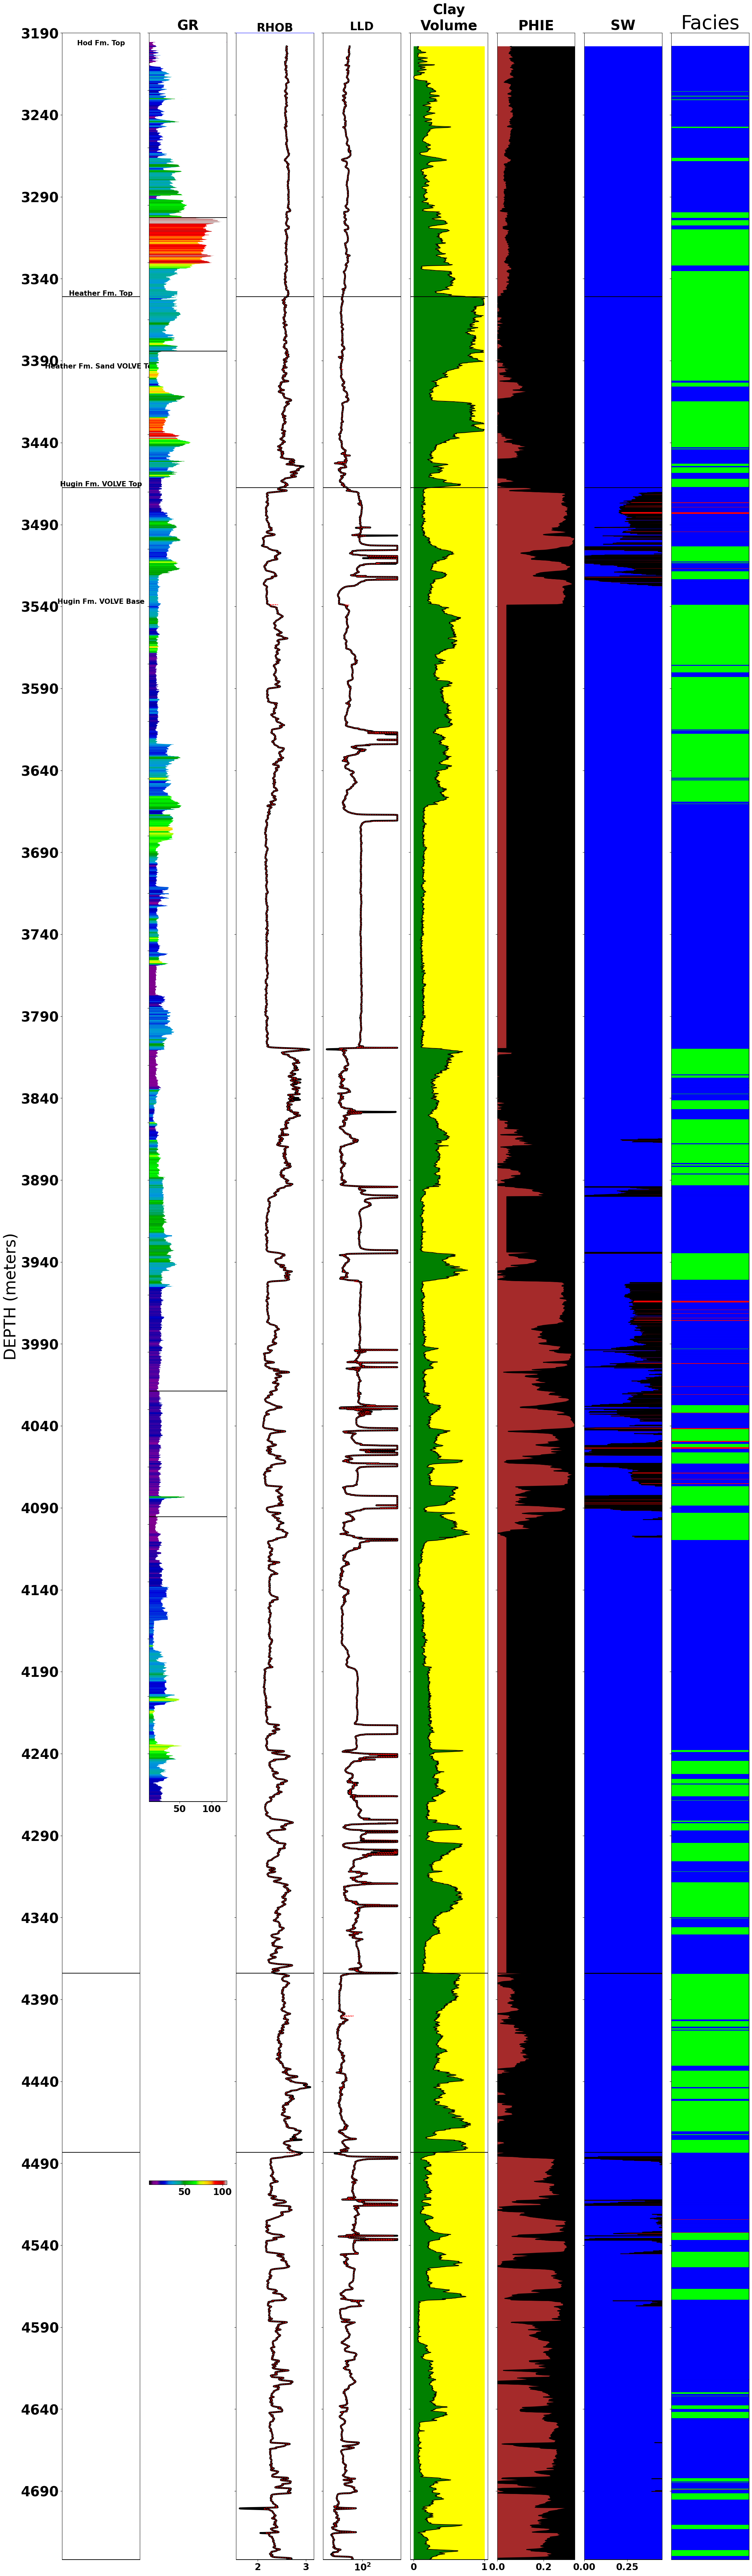

In [158]:
import matplotlib
warnings.filterwarnings("ignore")
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=30)
font = {'size'   : 35,
        'weight' : 'bold'}
matplotlib.rc('font', **font)
zone_colours = ["blue","red"]
plotting = ["Formation","GR","RHOB","LLD","VCL","Effective Porosity","SW","Facies"]
fig,ax = plt.subplots(nrows=1,ncols=len(plotting),figsize=(27,100),sharey=True)
fig.subplots_adjust(wspace=0.12)
for j,i in enumerate(plotting):
    if i=="Formation":
        for aj,ai in enumerate(tops_depth):
            ax[j].text( x = 0.5,  y = tops_depth[aj], s = forms[aj],fontsize = '15', 
                    horizontalalignment = 'center',verticalalignment = 'bottom')
            ax[j].grid(False)
            ax[j].set_xticks([])
    elif i=="RHOB":
        ax[j].plot(a[i],a["DEPTH"],label="RHOB",linewidth=4,color="black")
        ax[j].plot(a["CORR RHOB"],a["DEPTH"],color="red",linewidth=1,linestyle="--",label="PRED RHOB")
        ax[j].spines["top"].set_position(("axes", 1))

        ax[j].spines["top"].set_visible(True)
        ax[j].spines["top"].set_edgecolor("blue")
        ax[j].set_xlabel("RHOB",fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].xaxis.set_label_position("top")
#         ax[j].legend(loc=1,fontsize=15)
    elif i=="LLD":
        ax[j].semilogx(a[i],a["DEPTH"],label="ILD",linewidth=4,color="black")
        ax[j].semilogx(a["CORR LLD"],a["DEPTH"],color="red",linewidth=1,linestyle="--",label="CORR ILD")
        ax[j].set_title(i,fontdict={"fontsize":25,"fontweight":'bold'})
#         ax[j].legend(loc=1,fontsize=15)
   
    elif i=="CALI":
        ax[j].plot(a["CALI"],a["DEPTH"],color="red",label="CALI")
        ax[j].set_title(i,fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].legend(loc=1,fontsize=15)
    elif i=="DT":
        ax[j].plot(a[i],a["DEPTH"])
        ax[j].plot(a["CORR DT"],a["DEPTH"],color="red",label="CORR DT",linewidth=1,linestyle="--")
        
        ax[j].spines["top"].set_position(("axes", 1))

        ax[j].spines["top"].set_visible(True)
        ax[j].set_xlabel("DT",fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].xaxis.set_label_position("top")
        ax[j].legend(loc=1,fontsize=15)

    elif i=="NPHI":
        ax[j].plot(a[i],a["DEPTH"],label="NPHI",linewidth=4,color="black")
        ax[j].plot(a["CORR NPHI"],a["DEPTH"],color="red",label="CORR NPHI",linewidth=1,linestyle="--")
        ax[j].spines["top"].set_position(("axes", 1))
        ax[j].spines["top"].set_visible(True)
        ax[j].set_xlabel("NPHI",fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].xaxis.set_label_position("top")
        ax[j].legend(loc=1,fontsize=15)


    elif i=="crossover":
        x1=a['CORR RHOB']
        x2=a['CORR NPHI']
        x = np.array([x1.min(),x1.max()])
        z = np.array([x2.min(),x2.max()])
        nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)
        ax[j].fill_betweenx(a['DEPTH'], x1, nz, where=x1>=nz, interpolate=True, color='green')
        ax[j].fill_betweenx(a['DEPTH'], x1, nz, where=x1<=nz, interpolate=True, color='yellow')

        ax[j].plot(a["CORR RHOB"],a["DEPTH"],color="red",label="RHOB")
        ax[j].set_xlim([a["CORR RHOB"].min(),a["CORR RHOB"].max()])
        ax[j].set_xticks([])
        ax[j] = ax[j].twiny()
        ax[j].plot(a["CORR NPHI"],a["DEPTH"],color="blue",label="NPHI")
        ax[j].set_xlim([a["CORR NPHI"].max(),a["CORR NPHI"].min()])
       
        ax[j].spines["top"].set_position(("axes", 1))
        ax[j].spines["top"].set_visible(True)
        ax[j].spines["top"].set_edgecolor("blue")
        ax[j].set_xlim([a["CORR NPHI"].max(),a["CORR NPHI"].min()])
        
        ax[j].set_xticks([])
        ax[j].set_xlabel("Crossover",fontdict={"fontsize":15,"fontweight":'bold'})

    
    elif i=="VCL":
        ax[j].fill_betweenx(a['DEPTH'],a["VCL"],0, interpolate=True, color='green')
        ax[j].fill_betweenx(a['DEPTH'],1,a["VCL"], interpolate=True, color='yellow')
        ax[j].plot(a["VCL"],a["DEPTH"],color="black")
        
        ax[j].set_title("Clay\nVolume",fontdict={"fontsize":30,"fontweight":'bold'})
        
    elif i=="Effective Porosity":
        ax[j].fill_betweenx(a['DEPTH'],a["Effective Porosity"],0, interpolate=True, color='brown')
        ax[j].fill_betweenx(a['DEPTH'],1,a["Effective Porosity"], interpolate=True, color='black')
        ax[j].plot(a["Effective Porosity"],a["DEPTH"],color="black")
        ax[j].set_xlim([0,a["Effective Porosity"].max()])
        ax[j].set_title("PHIE",fontdict={"fontsize":30,"fontweight":'bold'})
    elif i=="SW":
        ax[j].fill_betweenx(a['DEPTH'],a["SW"],0, interpolate=True, color='blue')
        ax[j].fill_betweenx(a['DEPTH'],1,a["SW"], interpolate=True, color='red')
        ax[j].plot(a["SW"],a["DEPTH"],color="black")
        ax[j].set_xlim([0,0.45])
        ax[j].set_title("SW",fontdict={"fontsize":30,"fontweight":'bold'})
    

    elif i=="GR":
    
        a0 = ax[j].imshow(gr,aspect="auto",cmap="nipy_spectral",extent=[a["GR"].min(),a["GR"].max(),a["DEPTH"].max(),a["DEPTH"].min()])
        fig.colorbar(a0,orientation="horizontal")
        ax[j].fill_betweenx(a['DEPTH'],a["GR"], a["GR"].max(), interpolate=True, color='white')
        ax[j].set_title(i,fontdict={"fontsize":30,"fontweight":'bold'})
        ax[j].grid(False)

        ax[j].set_title(i,fontdict={"fontsize":30,"fontweight":'bold'})

    elif i=="crossover":

        x1=a['PRED RHOB']
        x2=a['NPHI']
        x = np.array([x1.min(),x1.max()])
        z = np.array([x2.min(),x2.max()])
        nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)
        ax[j].fill_betweenx(a['DEPTH'], x1, nz, where=x1>=nz, interpolate=True, color='green')
        ax[j].fill_betweenx(a['DEPTH'], x1, nz, where=x1<=nz, interpolate=True, color='yellow')

        ax[j].plot(a["CORR RHOB"],a["DEPTH"],color="red",label="RHOB")
        ax[j].set_xlim([a["RHOB"].min(),a["RHOB"].max()])
        ax[j].set_xticks([])
        ax[j] = ax[j].twiny()
        ax[j].plot(a["NPHI"],a["DEPTH"],color="blue",label="CORR NPHI")
        ax[j].set_xlim([a["NPHI"].max(),a["NPHI"].min()])
       
        ax[j].spines["top"].set_position(("axes", 1))
        ax[j].spines["top"].set_visible(True)
        ax[j].spines["top"].set_edgecolor("blue")
        ax[j].set_xlim([a["NPHI"].max(),a["NPHI"].min()])
        
        ax[j].set_xticks([])
        ax[j].set_xlabel("Crossover",fontdict={"fontsize":30,"fontweight":'bold'})
    elif i=="Facies":
        left_col_value = 0
        right_col_value = 3
        curve = a['Facies']
        span = abs(left_col_value - right_col_value)
        cmap = facies_color
        color_index = np.arange(left_col_value, right_col_value, span / 100)
        ax[j].plot('Facies','DEPTH', c='black', lw=0.5,data=a)
        for index in sorted(color_index):
            index_value = (index - left_col_value)/span
            color = cmap(index_value) #obtain colour for color index value
            ax[j].fill_betweenx(a['DEPTH'], 0 , curve, where = curve >= index,  color = color)
        ax[j].set_xlim([0,1])
        ax[j].set_title("Facies")
        ax[j].set_xticks([])
    
    elif (i!="Formation")&(i!="crossover")&(i!="Facies"):
        ax[j].plot(a[i],a["DEPTH"])
        ax[j].set_xticks([])
        ax[j].set_title(i,fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].legend(loc=1,fontsize=15)

        
    
    for k,i in enumerate(lims):
        if j!=len(plotting)-1:
            ax[j].axhline(i[1], color = 'black')     
    ax[0].set_ylabel("DEPTH (meters)")
    ax[0].set_yticks(np.flip(np.arange(int(a["DEPTH"].min()/10)*10,int(a["DEPTH"].max()/10)*10,50)))

   Average Porosity      VCL  Effective Porosity        SW  Pay Thickness
0          0.220906  0.26968            0.201924  0.290804          107.0


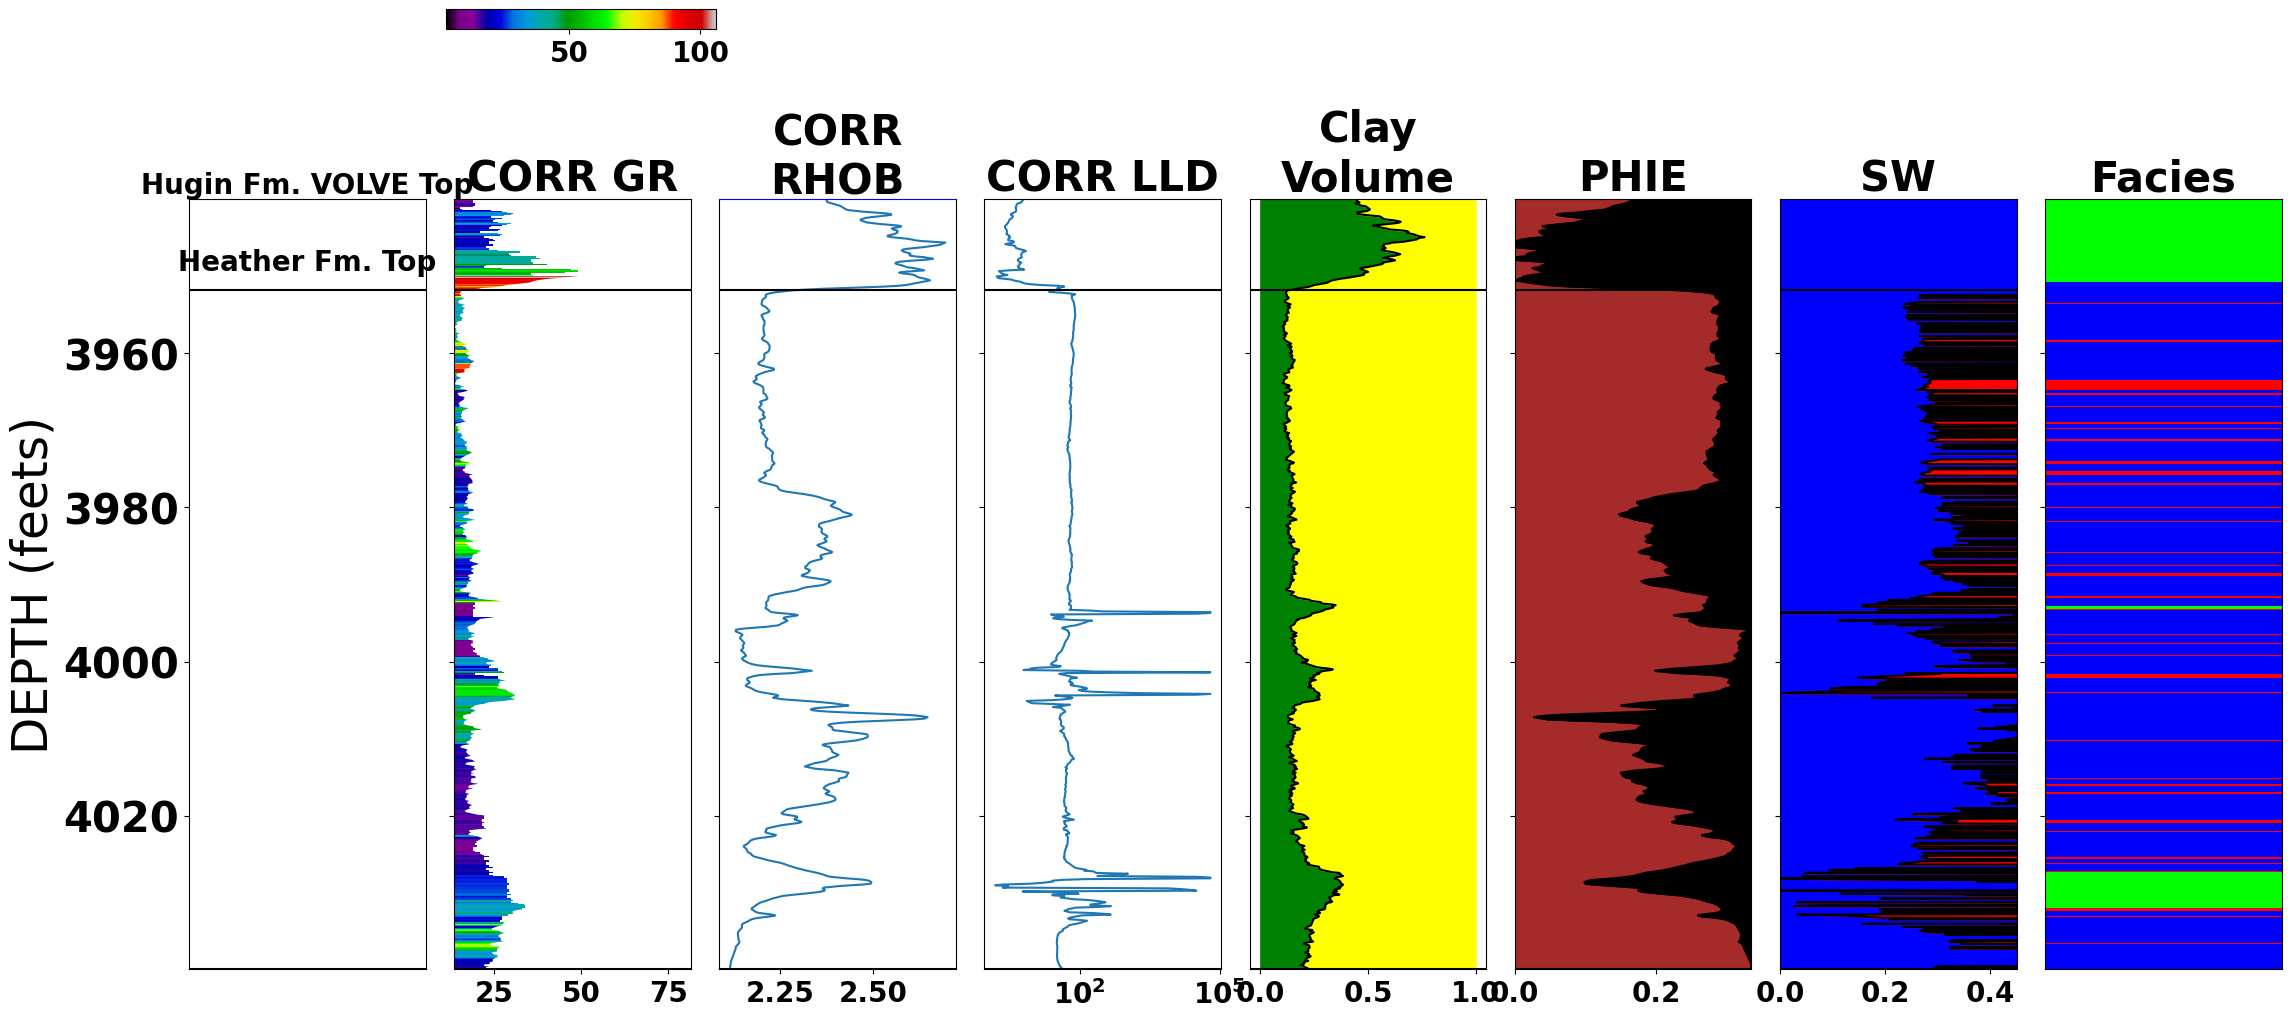

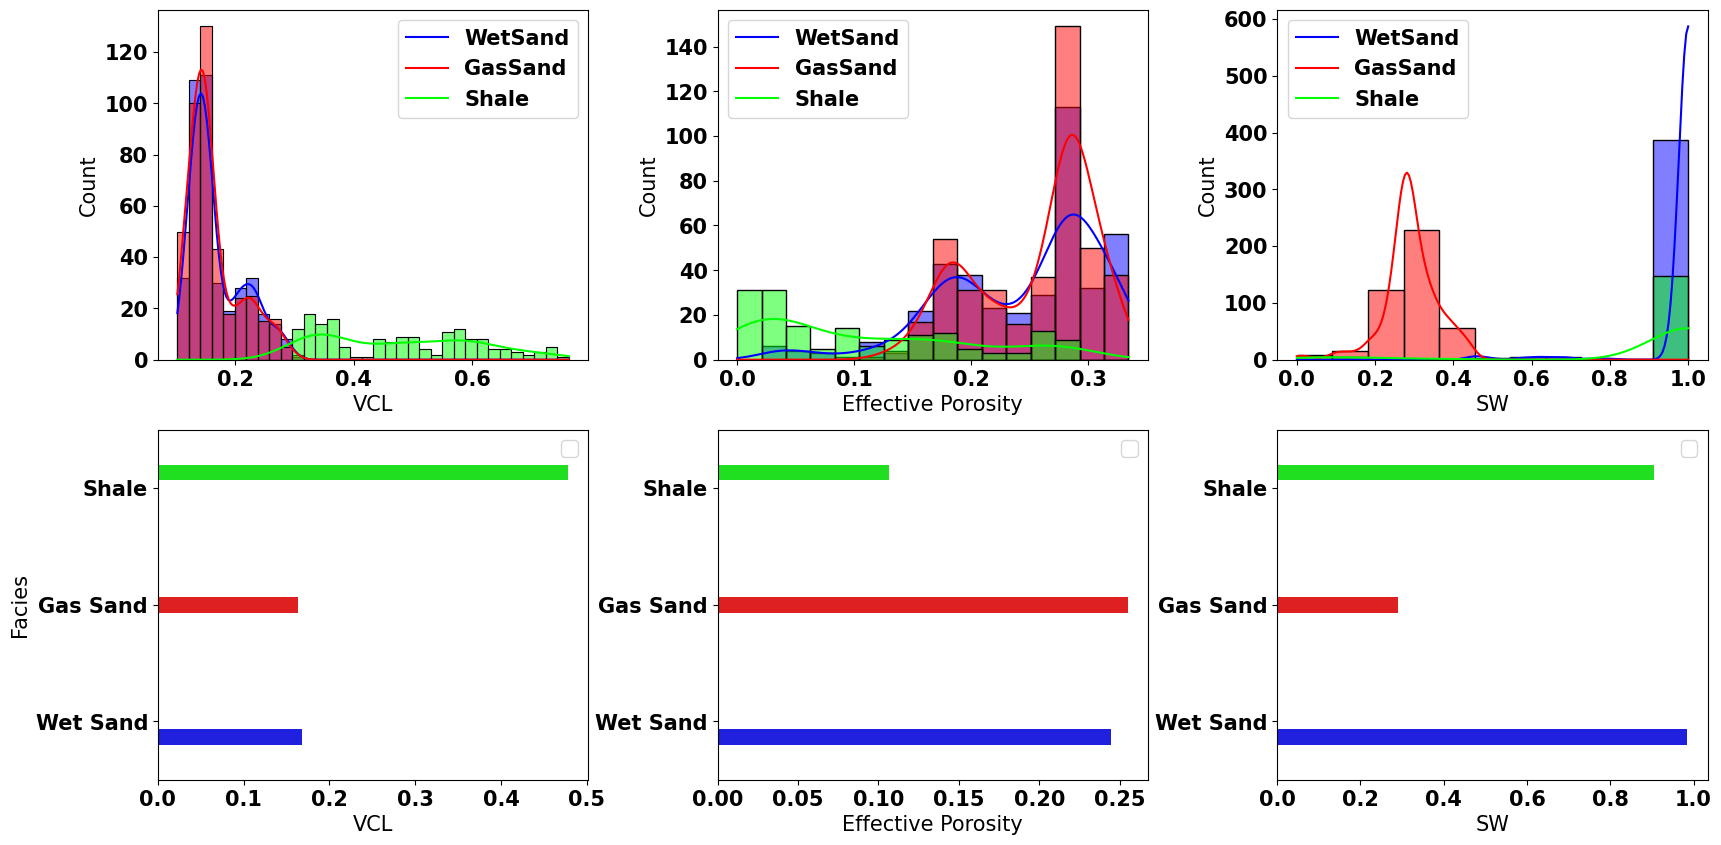

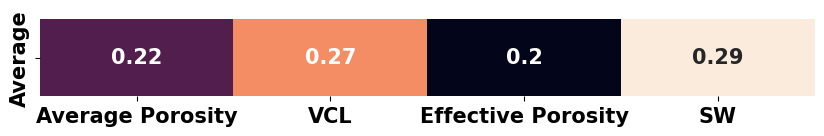

In [159]:
cos(3940,4040)

# LAS write

In [173]:
# a = a.drop(columns=["Formation"])

In [168]:
las_file = lasio.LASFile()
well_name = '15_9-F-11B'
field_name = 'Volve'
uwi = ''
country = ''
las_file.well['WELL'] = lasio.HeaderItem('WELL', value=well_name)
las_file.well['FLD'] = lasio.HeaderItem('FLD', value=field_name)
las_file.well['UWI'] = lasio.HeaderItem('UWI', value=uwi)
las_file.well['CTRY'] = lasio.HeaderItem('CTRY', value=country)
las_file.insert_curve(0,'DEPTH', a['DEPTH'], unit='m')

i=1
for col, unit in zip(a.columns, units):
    if col != 'DEPTH':
        i=i+1
        las_file.insert_curve(i,col, data=a[col], unit='')

In [169]:
las_file.write(r'.\Out\15_9-F-11B.las')